# 📊 Internship Assignment – DeFi Wallet Anomaly & Scoring Analysis

**Applicant**: Sarthak Maddi  
**Role**: AI Engineer Intern  
**Date**: 19/08/2025  


## 🎯 Objective  

Analyze wallet-level liquidity provider (LP) scoring data (~100K records) to:  
- Detect anomalies and outliers in liquidity and behavior metrics.  
- Reverse-engineer how the **aggregated LP score** is calculated.  
- Provide insights into user activity patterns across pools.  
- Summarize findings in a concise, student-style report.  

### Dataset Overview  
- Loaded dataset `dex-temp-db.score_v4.csv`.  
- Shape checked → rows and columns confirmed.  
- Previewed first 3 rows to see structure.  
- Counted missing values to spot nulls.  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("dataset/dex-temp-db.score_v4.csv", low_memory=False)
print("Shape:", df.shape)
print("Columns:", len(df.columns))
df.head(3)

Shape: (44975, 396)
Columns: 396


,_id,wallet_id,lp_scores[0].pool_id,lp_scores[1].pool_id,lp_scores[2].pool_id,lp_scores[3].pool_id,lp_scores[4].pool_id,lp_scores[5].pool_id,lp_scores[6].pool_id,lp_scores[7].pool_id,...,lp_scores[7].last_tx_timestamp,lp_scores[8].last_tx_timestamp,lp_scores[9].last_tx_timestamp,lp_scores[10].last_tx_timestamp,lp_scores[11].last_tx_timestamp,lp_scores[12].last_tx_timestamp,aggregated_lp_score,lp_category_breakdown.stable-stable,lp_category_breakdown.stable-volatile,lp_category_breakdown.volatile-volatile
0,6874b820a794db5e6c4c2dbf,0x0057d4a850e34bac84ed297f14ba146747b90272,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,147.00,0.0,147.0,0.000000
1,6874b820a794db5e6c4c2dc8,0x00819eb70be2aecee2915ed76f9bb6ca2cfbd390,0x4ccd010148379ea531d6c587cfdd60180196f9b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,52.00,0.0,52.0,0.000000
2,6874b821a794db5e6c4c2dee,0x00d4c206ae699d5d2bf19a542a544276dc50889c,0x167384319b41f7094e62f7506409eb38079abff8,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,296.56,0.0,0.0,348.895306


In [3]:
df.isnull().sum()

_id                                            0
wallet_id                                      0
lp_scores[0].pool_id                           0
lp_scores[1].pool_id                       36337
lp_scores[2].pool_id                       43076
                                           ...  
lp_scores[12].last_tx_timestamp            44974
aggregated_lp_score                            0
lp_category_breakdown.stable-stable            0
lp_category_breakdown.stable-volatile          0
lp_category_breakdown.volatile-volatile        0
Length: 396, dtype: int64

### Negative Values Check  
- Picked all numeric columns (scores, deposits, withdrawals, liquidity, etc.).  
- Converted them to numeric for safety.  
- Checked duplicates by wallet → none major.  
- Found some negative values in liquidity-related fields.  
- Around **26849 wallets** had negative retained liquidity (saved in `negative_liquidity_anomalies.csv`).  
- Fixed this by clipping negative liquidity values to zero.  


In [4]:
numeric_cols = [c for c in df.columns 
                if ("score" in c 
                    or "deposit" in c 
                    or "withdraw" in c 
                    or "liquidity" in c 
                    or "holding" in c 
                    or "volatility" in c)
                and "pool_id" not in c   
                and "pool_name" not in c 
                and "token_symbols" not in c] 

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")


In [5]:
df.duplicated(subset=["wallet_id"]).sum()

np.int64(0)

In [6]:
(df[numeric_cols] < 0).sum().sum()

np.int64(31999)

In [7]:
negatives_per_col = (df[numeric_cols] < 0).sum()
print(negatives_per_col)
negatives_per_col[negatives_per_col > 0]

lp_scores[0].timestamp             0
lp_scores[1].timestamp             0
lp_scores[2].timestamp             0
lp_scores[3].timestamp             0
lp_scores[4].timestamp             0
                                  ..
lp_scores[9].last_tx_timestamp     0
lp_scores[10].last_tx_timestamp    0
lp_scores[11].last_tx_timestamp    0
lp_scores[12].last_tx_timestamp    0
aggregated_lp_score                0
Length: 339, dtype: int64


lp_scores[0].retained_liquidity     24671
lp_scores[1].retained_liquidity      5596
lp_scores[2].retained_liquidity      1256
lp_scores[3].retained_liquidity       308
lp_scores[4].retained_liquidity       108
lp_scores[5].retained_liquidity        23
lp_scores[6].retained_liquidity        15
lp_scores[7].retained_liquidity         9
lp_scores[8].retained_liquidity         5
lp_scores[9].retained_liquidity         3
lp_scores[10].retained_liquidity        3
lp_scores[11].retained_liquidity        2
dtype: int64

In [8]:
df[df[numeric_cols].lt(0).any(axis=1)].head(10)

,_id,wallet_id,lp_scores[0].pool_id,lp_scores[1].pool_id,lp_scores[2].pool_id,lp_scores[3].pool_id,lp_scores[4].pool_id,lp_scores[5].pool_id,lp_scores[6].pool_id,lp_scores[7].pool_id,...,lp_scores[7].last_tx_timestamp,lp_scores[8].last_tx_timestamp,lp_scores[9].last_tx_timestamp,lp_scores[10].last_tx_timestamp,lp_scores[11].last_tx_timestamp,lp_scores[12].last_tx_timestamp,aggregated_lp_score,lp_category_breakdown.stable-stable,lp_category_breakdown.stable-volatile,lp_category_breakdown.volatile-volatile
0,6874b820a794db5e6c4c2dbf,0x0057d4a850e34bac84ed297f14ba146747b90272,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,147.00,0.0,147.000000,0.000000
2,6874b821a794db5e6c4c2dee,0x00d4c206ae699d5d2bf19a542a544276dc50889c,0x167384319b41f7094e62f7506409eb38079abff8,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,296.56,0.0,0.000000,348.895306
3,6874b822a794db5e6c4c2e23,0x0052830c57696794e3999ed44dd2bb20d286a19b,0xdfcfdf5dd0569d591e0bce28b5da3b13de09e3cb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,341.70,0.0,0.000000,402.000000
4,6874b822a794db5e6c4c2e3f,0x007c70e81c0430f39c965a0819293e1745f1e443,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,284.00,0.0,284.000000,0.000000
7,6874b828a794db5e6c4c2f25,0x013e9d280d9716e5ed41eb1641c92937ac36b4a5,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,242.25,0.0,0.000000,285.000000
8,6874b829a794db5e6c4c2f38,0x011c0b0dc1dc2125c2a310240ece961436112a63,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,372.00,0.0,372.000000,0.000000
9,6874b81ea794db5e6c4c2d92,0x0041ff590cca6e1077075678c24bad5b5fb95452,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,255.00,0.0,255.000000,0.000000
10,6874b821a794db5e6c4c2df7,0x002fe502a3c31fb20340829cee70d95f5f85a535,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,213.70,0.0,213.698231,0.000000
13,6874b822a794db5e6c4c2e49,0x00e7737af473fb9d19892c5de81b2f2b0ba2789f,0x167384319b41f7094e62f7506409eb38079abff8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,249.05,0.0,0.000000,293.000000
14,6874b823a794db5e6c4c2e67,0x0079847320e894982cfd50b665c15b329cb33806,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,396.10,0.0,0.000000,466.000000


In [9]:
neg_wallets = df[df[numeric_cols].lt(0).any(axis=1)]["wallet_id"].nunique()
print("Wallets with negative retained liquidity:", neg_wallets)

Wallets with negative retained liquidity: 26849


In [10]:
neg_anomalies = df[df[numeric_cols].lt(0).any(axis=1)][["_id","wallet_id"] + [c for c in df.columns if "retained_liquidity" in c]]
neg_anomalies.to_csv("anomalies_csv/negative_liquidity_anomalies.csv", index=False)
neg_anomalies

,_id,wallet_id,lp_scores[0].retained_liquidity,lp_scores[1].retained_liquidity,lp_scores[2].retained_liquidity,lp_scores[3].retained_liquidity,lp_scores[4].retained_liquidity,lp_scores[5].retained_liquidity,lp_scores[6].retained_liquidity,lp_scores[7].retained_liquidity,lp_scores[8].retained_liquidity,lp_scores[9].retained_liquidity,lp_scores[10].retained_liquidity,lp_scores[11].retained_liquidity,lp_scores[12].retained_liquidity
0,6874b820a794db5e6c4c2dbf,0x0057d4a850e34bac84ed297f14ba146747b90272,-1.389478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6874b821a794db5e6c4c2dee,0x00d4c206ae699d5d2bf19a542a544276dc50889c,-61.545989,20262.321680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6874b822a794db5e6c4c2e23,0x0052830c57696794e3999ed44dd2bb20d286a19b,-3263.061206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6874b822a794db5e6c4c2e3f,0x007c70e81c0430f39c965a0819293e1745f1e443,-45.918744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,6874b828a794db5e6c4c2f25,0x013e9d280d9716e5ed41eb1641c92937ac36b4a5,-296.251737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44966,6874c630a794db5e6c4dacef,0xffd0d478c7098b49e720a44a6ee5ee13b6334416,-8.053848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44968,6874c631a794db5e6c4dad28,0xffec6e528ef93ee21776db059d523047d60cf0db,-132.780818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44969,6874c632a794db5e6c4dad41,0xff6e64d21b5420b53cbaa4505dfcda49786a2a3b,-17.202397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44972,6874c633a794db5e6c4dadba,0xff1fee4c1b25ef5d6162efba0d9c999b1eb648af,-1471.263604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df[[c for c in df.columns if "retained_liquidity" in c]] =  df[[c for c in df.columns if "retained_liquidity" in c]].clip(lower=0)

In [12]:
negatives_per_col = (df[numeric_cols] < 0).sum()
print(negatives_per_col)
negatives_per_col[negatives_per_col > 0]

lp_scores[0].timestamp             0
lp_scores[1].timestamp             0
lp_scores[2].timestamp             0
lp_scores[3].timestamp             0
lp_scores[4].timestamp             0
                                  ..
lp_scores[9].last_tx_timestamp     0
lp_scores[10].last_tx_timestamp    0
lp_scores[11].last_tx_timestamp    0
lp_scores[12].last_tx_timestamp    0
aggregated_lp_score                0
Length: 339, dtype: int64


Series([], dtype: int64)

### 🔎 Data checks (liquidity & holding times)

- Checked if `retained_liquidity` > `total_deposit_all_time` → should not happen.  
- Verified holding days: `min ≤ avg ≤ max`. If not, data is inconsistent.  
- Some wallets have min=avg=max (like 949 days) → valid case.  
- Also converted all timestamp columns to datetime for easy use.  


In [13]:
liquidity_issues = []
for i in range(13):   # pools 0 to 12
    retained = f"lp_scores[{i}].retained_liquidity"
    deposited = f"lp_scores[{i}].total_deposit_all_time"
    if retained in df.columns and deposited in df.columns:
        count = (df[retained] > df[deposited]).sum()
        if count > 0:
            print(f"Pool {i}: {count} rows where retained > deposited")


In [14]:
holding_issues = []
for i in range(13):   # pools 0 to 12
    min_c = f"lp_scores[{i}].min_holding_days"
    avg_c = f"lp_scores[{i}].avg_holding_days"
    max_c = f"lp_scores[{i}].max_holding_days"
    if min_c in df.columns and avg_c in df.columns and max_c in df.columns:
        count = df[(df[min_c] > df[avg_c]) | (df[avg_c] > df[max_c])].shape[0]
        if count > 0:
            print(f"Pool {i}: {count} rows with inconsistent holding times")


Pool 1: 1 rows with inconsistent holding times


In [15]:
bad_holding = df[(df["lp_scores[1].min_holding_days"] > df["lp_scores[1].avg_holding_days"]) | 
                 (df["lp_scores[1].avg_holding_days"] > df["lp_scores[1].max_holding_days"])]

bad_holding[["wallet_id", "lp_scores[1].min_holding_days", 
             "lp_scores[1].avg_holding_days", "lp_scores[1].max_holding_days"]]
# Some wallets may have min = avg = max holding days (e.g., 949 days).
# This is valid (single holding period) and not a true anomaly, so we keep them.

,wallet_id,lp_scores[1].min_holding_days,lp_scores[1].avg_holding_days,lp_scores[1].max_holding_days
11417,0x4023ef3aaa0669faaf3a712626f4d8ccc3eaf2e5,949.929412,949.929412,949.929412


In [16]:
time_cols = [c for c in df.columns if "timestamp" in c]
df[time_cols] = df[time_cols].apply(pd.to_datetime, errors="coerce")


### 📊 Aggregated vs Pool Scores

- Plotted distribution of `aggregated_lp_score` → most scores are mid-range.  
- Counted pools per wallet (median ~1, max 13).  
- Compared `aggregated_lp_score` with sum of pool scores.  
- Found correlation ~0.63 → related but not equal.  
- Sum of pool scores often > aggregated score → some weighting/normalization is used.  


In [17]:
df["aggregated_lp_score"].describe()

count    44975.000000
mean       303.328327
std        139.656040
min         45.000000
25%        223.255000
50%        296.650000
75%        382.975000
max        937.250000
Name: aggregated_lp_score, dtype: float64

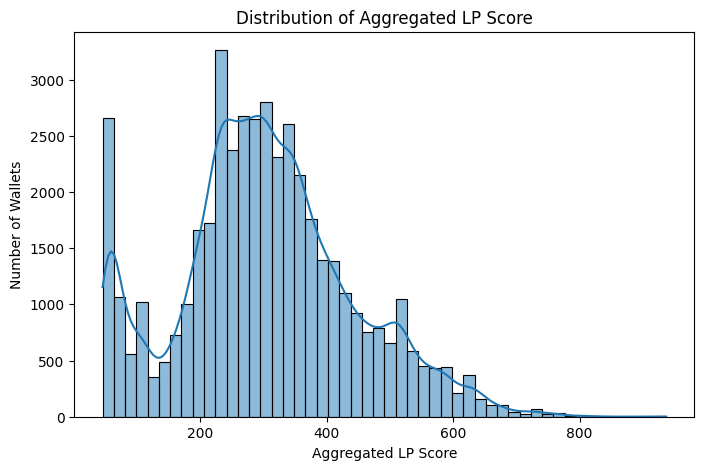

In [18]:
plt.figure(figsize=(8,5))
sns.histplot(df["aggregated_lp_score"], bins=50, kde=True)
plt.title("Distribution of Aggregated LP Score")
plt.xlabel("Aggregated LP Score")
plt.ylabel("Number of Wallets")
plt.show()


In [19]:
df.head()

,_id,wallet_id,lp_scores[0].pool_id,lp_scores[1].pool_id,lp_scores[2].pool_id,lp_scores[3].pool_id,lp_scores[4].pool_id,lp_scores[5].pool_id,lp_scores[6].pool_id,lp_scores[7].pool_id,...,lp_scores[7].last_tx_timestamp,lp_scores[8].last_tx_timestamp,lp_scores[9].last_tx_timestamp,lp_scores[10].last_tx_timestamp,lp_scores[11].last_tx_timestamp,lp_scores[12].last_tx_timestamp,aggregated_lp_score,lp_category_breakdown.stable-stable,lp_category_breakdown.stable-volatile,lp_category_breakdown.volatile-volatile
0,6874b820a794db5e6c4c2dbf,0x0057d4a850e34bac84ed297f14ba146747b90272,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,147.00,0.0,147.0,0.000000
1,6874b820a794db5e6c4c2dc8,0x00819eb70be2aecee2915ed76f9bb6ca2cfbd390,0x4ccd010148379ea531d6c587cfdd60180196f9b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,52.00,0.0,52.0,0.000000
2,6874b821a794db5e6c4c2dee,0x00d4c206ae699d5d2bf19a542a544276dc50889c,0x167384319b41f7094e62f7506409eb38079abff8,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,296.56,0.0,0.0,348.895306
3,6874b822a794db5e6c4c2e23,0x0052830c57696794e3999ed44dd2bb20d286a19b,0xdfcfdf5dd0569d591e0bce28b5da3b13de09e3cb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,341.70,0.0,0.0,402.000000
4,6874b822a794db5e6c4c2e3f,0x007c70e81c0430f39c965a0819293e1745f1e443,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,284.00,0.0,284.0,0.000000


In [20]:
pool_cols = [c for c in df.columns if "pool_id" in c]

df["num_pools"] = df[pool_cols].notna().sum(axis=1)
df.head()

C:\Users\msart\AppData\Local\Temp\ipykernel_25088\4003214925.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["num_pools"] = df[pool_cols].notna().sum(axis=1)


,_id,wallet_id,lp_scores[0].pool_id,lp_scores[1].pool_id,lp_scores[2].pool_id,lp_scores[3].pool_id,lp_scores[4].pool_id,lp_scores[5].pool_id,lp_scores[6].pool_id,lp_scores[7].pool_id,...,lp_scores[8].last_tx_timestamp,lp_scores[9].last_tx_timestamp,lp_scores[10].last_tx_timestamp,lp_scores[11].last_tx_timestamp,lp_scores[12].last_tx_timestamp,aggregated_lp_score,lp_category_breakdown.stable-stable,lp_category_breakdown.stable-volatile,lp_category_breakdown.volatile-volatile,num_pools
0,6874b820a794db5e6c4c2dbf,0x0057d4a850e34bac84ed297f14ba146747b90272,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,147.00,0.0,147.0,0.000000,1
1,6874b820a794db5e6c4c2dc8,0x00819eb70be2aecee2915ed76f9bb6ca2cfbd390,0x4ccd010148379ea531d6c587cfdd60180196f9b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,52.00,0.0,52.0,0.000000,1
2,6874b821a794db5e6c4c2dee,0x00d4c206ae699d5d2bf19a542a544276dc50889c,0x167384319b41f7094e62f7506409eb38079abff8,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,296.56,0.0,0.0,348.895306,2
3,6874b822a794db5e6c4c2e23,0x0052830c57696794e3999ed44dd2bb20d286a19b,0xdfcfdf5dd0569d591e0bce28b5da3b13de09e3cb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,341.70,0.0,0.0,402.000000,1
4,6874b822a794db5e6c4c2e3f,0x007c70e81c0430f39c965a0819293e1745f1e443,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,284.00,0.0,284.0,0.000000,1


In [21]:
df["num_pools"].describe()

count    44975.000000
mean         1.249805
std          0.593925
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         13.000000
Name: num_pools, dtype: float64

In [22]:
df["num_pools"].value_counts().sort_index()

num_pools
1     36337
2      6739
3      1425
4       333
5       107
6        13
7        11
8         3
9         2
10        2
11        1
12        1
13        1
Name: count, dtype: int64

In [23]:
df =df.copy()
pool_score_cols = [c for c in df.columns if "lp_scores" in c and ".total_score" in c]
df["sum_pool_scores"] = df[pool_score_cols].sum(axis=1)
df

,_id,wallet_id,lp_scores[0].pool_id,lp_scores[1].pool_id,lp_scores[2].pool_id,lp_scores[3].pool_id,lp_scores[4].pool_id,lp_scores[5].pool_id,lp_scores[6].pool_id,lp_scores[7].pool_id,...,lp_scores[9].last_tx_timestamp,lp_scores[10].last_tx_timestamp,lp_scores[11].last_tx_timestamp,lp_scores[12].last_tx_timestamp,aggregated_lp_score,lp_category_breakdown.stable-stable,lp_category_breakdown.stable-volatile,lp_category_breakdown.volatile-volatile,num_pools,sum_pool_scores
0,6874b820a794db5e6c4c2dbf,0x0057d4a850e34bac84ed297f14ba146747b90272,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,147.00,0.0,147.0,0.000000,1,294.0
1,6874b820a794db5e6c4c2dc8,0x00819eb70be2aecee2915ed76f9bb6ca2cfbd390,0x4ccd010148379ea531d6c587cfdd60180196f9b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,52.00,0.0,52.0,0.000000,1,104.0
2,6874b821a794db5e6c4c2dee,0x00d4c206ae699d5d2bf19a542a544276dc50889c,0x167384319b41f7094e62f7506409eb38079abff8,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,296.56,0.0,0.0,348.895306,2,856.0
3,6874b822a794db5e6c4c2e23,0x0052830c57696794e3999ed44dd2bb20d286a19b,0xdfcfdf5dd0569d591e0bce28b5da3b13de09e3cb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,341.70,0.0,0.0,402.000000,1,804.0
4,6874b822a794db5e6c4c2e3f,0x007c70e81c0430f39c965a0819293e1745f1e443,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,284.00,0.0,284.0,0.000000,1,568.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44970,6874c632a794db5e6c4dad57,0xffedab0adacbc18c7fad6c420d47cb9a5c1152d7,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,277.95,0.0,0.0,327.000000,1,654.0
44971,6874c632a794db5e6c4dad89,0xff9b2edeaa85eb21460b4c51d84f70d8ab6009ee,0x50eaedb835021e4a108b7290636d62e9765cc6d7,0x7ec18abf80e865c6799069df91073335935c4185,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,228.42,0.0,0.0,268.731333,2,1142.0
44972,6874c633a794db5e6c4dadba,0xff1fee4c1b25ef5d6162efba0d9c999b1eb648af,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,387.60,0.0,0.0,456.000000,1,912.0
44973,6874c633a794db5e6c4dadc7,0xff54a5ee2f1d21593ce44929c746189b3550d7f6,0x167384319b41f7094e62f7506409eb38079abff8,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,302.14,0.0,0.0,355.455278,2,1384.0


In [24]:
df[["aggregated_lp_score", "sum_pool_scores"]].head(10)

,aggregated_lp_score,sum_pool_scores
0,147.00,294.0
1,52.00,104.0
2,296.56,856.0
3,341.70,804.0
4,284.00,568.0
5,496.00,992.0
6,545.70,1284.0
7,242.25,570.0
8,372.00,744.0
9,255.00,510.0


In [25]:
df["aggregated_lp_score"].corr(df["sum_pool_scores"])

np.float64(0.6345904298552673)

In [26]:
df[["aggregated_lp_score", "sum_pool_scores"]].describe()

,aggregated_lp_score,sum_pool_scores
count,44975.000000,44975.000000
mean,303.328327,785.763824
std,139.656040,490.771740
min,45.000000,80.000000
25%,223.255000,512.000000
50%,296.650000,696.000000
75%,382.975000,982.000000
max,937.250000,8970.000000


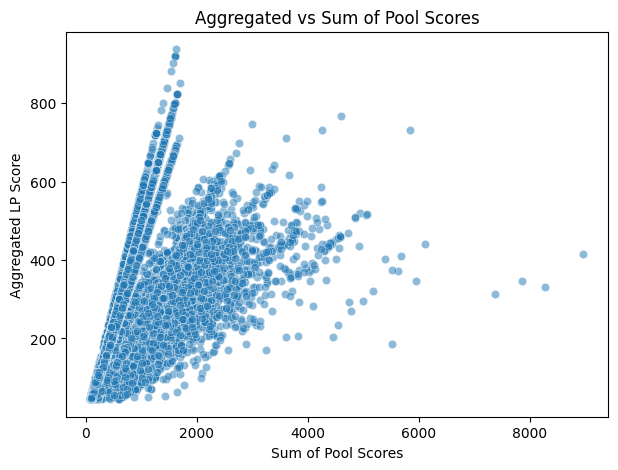

In [27]:
plt.figure(figsize=(7,5))
sns.scatterplot(x="sum_pool_scores", y="aggregated_lp_score", data=df, alpha=0.5)
plt.title("Aggregated vs Sum of Pool Scores")
plt.xlabel("Sum of Pool Scores")
plt.ylabel("Aggregated LP Score")
plt.show()

In [28]:
# Here we compare the "aggregated_lp_score" (final overall score for a wallet) 
# with the "sum of pool scores" (raw total of all pool scores for that wallet).
# We calculate the correlation and visualize with a scatterplot to check if 
# aggregated_lp_score is just a sum, or if some scaling/normalization is applied.
# Finding: The aggregated_lp_score is strongly related to pool scores but not a direct sum.  
# The sum of pool scores is usually about 2x or more than the aggregated score.  
# Correlation is ~0.63, so aggregation likely involves normalization or weighting.  

### 📈 Aggregated vs Mean Pool Score

- Tried `mean_pool_score` and `sum_pool_scores / num_pools` as alternatives.  
- Aggregated score aligns more with **mean pool score** (corr ~0.96).  
- Still not exact → other factors adjust the score.  
- Findings:  
  - Volatile–volatile pools seem to lower scores.  
  - Stable pools give slight boost.  
  - Liquidity retention sometimes pulls score down.  
  - Number of pools has small positive effect.  


In [29]:
df["mean_pool_score"] = df[pool_score_cols].mean(axis=1)
df["sum_div_pools"] = df["sum_pool_scores"] / df["num_pools"]
df.head()

,_id,wallet_id,lp_scores[0].pool_id,lp_scores[1].pool_id,lp_scores[2].pool_id,lp_scores[3].pool_id,lp_scores[4].pool_id,lp_scores[5].pool_id,lp_scores[6].pool_id,lp_scores[7].pool_id,...,lp_scores[11].last_tx_timestamp,lp_scores[12].last_tx_timestamp,aggregated_lp_score,lp_category_breakdown.stable-stable,lp_category_breakdown.stable-volatile,lp_category_breakdown.volatile-volatile,num_pools,sum_pool_scores,mean_pool_score,sum_div_pools
0,6874b820a794db5e6c4c2dbf,0x0057d4a850e34bac84ed297f14ba146747b90272,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,147.00,0.0,147.0,0.000000,1,294.0,147.0,294.0
1,6874b820a794db5e6c4c2dc8,0x00819eb70be2aecee2915ed76f9bb6ca2cfbd390,0x4ccd010148379ea531d6c587cfdd60180196f9b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,52.00,0.0,52.0,0.000000,1,104.0,52.0,104.0
2,6874b821a794db5e6c4c2dee,0x00d4c206ae699d5d2bf19a542a544276dc50889c,0x167384319b41f7094e62f7506409eb38079abff8,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,296.56,0.0,0.0,348.895306,2,856.0,214.0,428.0
3,6874b822a794db5e6c4c2e23,0x0052830c57696794e3999ed44dd2bb20d286a19b,0xdfcfdf5dd0569d591e0bce28b5da3b13de09e3cb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,341.70,0.0,0.0,402.000000,1,804.0,402.0,804.0
4,6874b822a794db5e6c4c2e3f,0x007c70e81c0430f39c965a0819293e1745f1e443,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,284.00,0.0,284.0,0.000000,1,568.0,284.0,568.0


In [30]:
df[["aggregated_lp_score","mean_pool_score", "sum_div_pools"]].head(10)

,aggregated_lp_score,mean_pool_score,sum_div_pools
0,147.00,147.0,294.0
1,52.00,52.0,104.0
2,296.56,214.0,428.0
3,341.70,402.0,804.0
4,284.00,284.0,568.0
5,496.00,496.0,992.0
6,545.70,642.0,1284.0
7,242.25,285.0,570.0
8,372.00,372.0,744.0
9,255.00,255.0,510.0


In [31]:
corr_mean = df["aggregated_lp_score"].corr(df["mean_pool_score"])
corr_sum_div = df["aggregated_lp_score"].corr(df["sum_div_pools"])
print("Correlation with mean pool score:", corr_mean)
print("Correlation with sum/num_pools:", corr_sum_div)

Correlation with mean pool score: 0.96481230537438
Correlation with sum/num_pools: 0.96481230537438


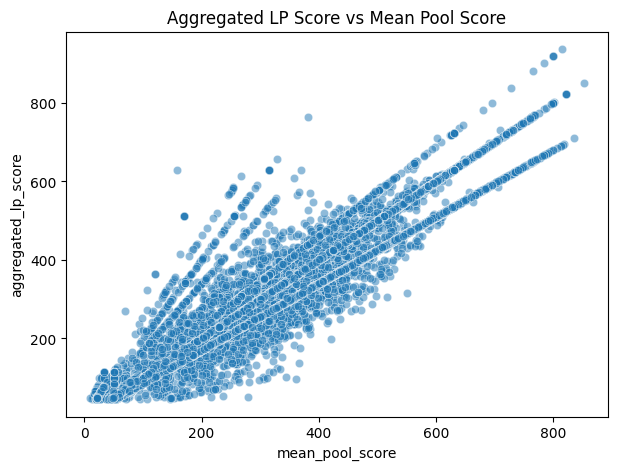

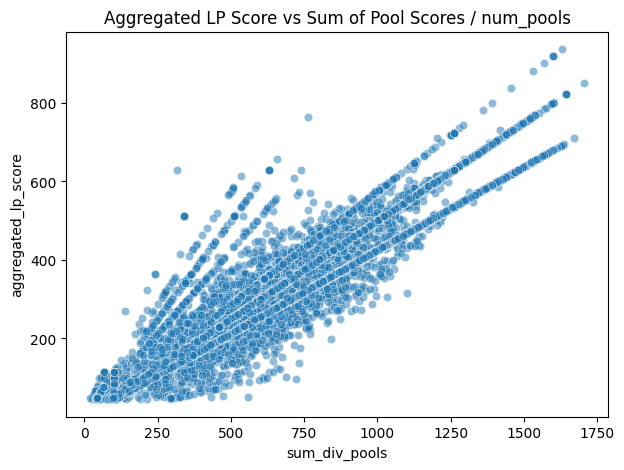

In [32]:
plt.figure(figsize=(7,5))
sns.scatterplot(x="mean_pool_score", y="aggregated_lp_score", data=df, alpha=0.5)
plt.title("Aggregated LP Score vs Mean Pool Score")
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(x="sum_div_pools", y="aggregated_lp_score", data=df, alpha=0.5)
plt.title("Aggregated LP Score vs Sum of Pool Scores / num_pools")
plt.show()

<Axes: xlabel='diff_mean', ylabel='Count'>

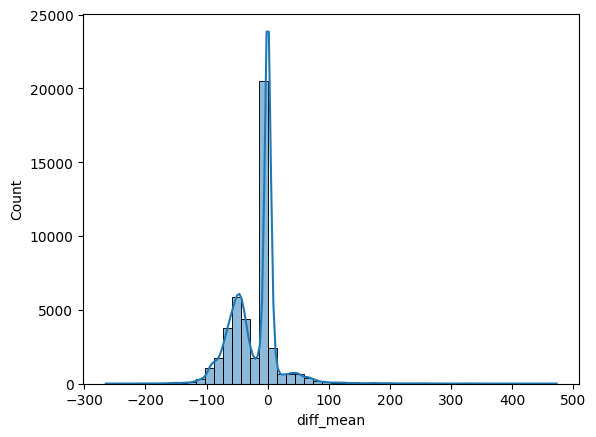

In [33]:
df["diff_mean"] = df["aggregated_lp_score"] - df["mean_pool_score"]
df["diff_mean"].describe()
sns.histplot(df["diff_mean"], bins=50, kde=True)


In [34]:
df["diff_mean"] = df["aggregated_lp_score"] - df["mean_pool_score"]

print("Corr with num_pools:", df["diff_mean"].corr(df["num_pools"]))


Corr with num_pools: 0.17315891730233052


In [35]:
cat_cols = [c for c in df.columns if "lp_category_breakdown" in c]
print(df[["diff_mean"] + cat_cols].corr()["diff_mean"])

diff_mean                                  1.000000
lp_category_breakdown.stable-stable        0.324207
lp_category_breakdown.stable-volatile      0.442530
lp_category_breakdown.volatile-volatile   -0.659980
Name: diff_mean, dtype: float64


In [36]:
liq_cols = [c for c in df.columns if "retained_liquidity" in c or "liquidity_percent_remaining" in c]
print(df[["diff_mean"] + liq_cols].corr()["diff_mean"])


diff_mean                                    1.000000
lp_scores[0].retained_liquidity             -0.033468
lp_scores[1].retained_liquidity             -0.003455
lp_scores[2].retained_liquidity             -0.008779
lp_scores[3].retained_liquidity              0.018479
lp_scores[4].retained_liquidity             -0.168225
lp_scores[5].retained_liquidity             -0.240590
lp_scores[6].retained_liquidity             -0.183671
lp_scores[7].retained_liquidity                   NaN
lp_scores[8].retained_liquidity             -0.488371
lp_scores[9].retained_liquidity             -0.588096
lp_scores[10].retained_liquidity                  NaN
lp_scores[11].retained_liquidity                  NaN
lp_scores[12].retained_liquidity                  NaN
lp_scores[0].liquidity_percent_remaining    -0.209580
lp_scores[1].liquidity_percent_remaining    -0.008471
lp_scores[2].liquidity_percent_remaining     0.036200
lp_scores[3].liquidity_percent_remaining     0.046286
lp_scores[4].liquidity_perce

In [37]:
# Key insight:
# Aggregated LP Score ≈ Mean Pool Score, but adjusted.
# - Volatile–volatile pools → penalty (score pulled down)
# - Stable pools → small boost
# - Liquidity (retention/remaining) sometimes lowers score
# - Number of pools → minor positive effect
# This explains why corr ~0.96, not 1.0.

### 🧩 Category Breakdown Check

- Compared sum of 3 category fields with aggregated score.  
- Correlation ~0.83 → related but not equal.  
- Only ~41% rows match exactly.  
- Aggregated score usually ~50+ higher → categories are more like diagnostics, not direct sub-scores.  


In [38]:
cat_cols = [
    "lp_category_breakdown.stable-stable",
    "lp_category_breakdown.stable-volatile",
    "lp_category_breakdown.volatile-volatile"
]

df["sum_category_scores"] = df[cat_cols].sum(axis=1)
df.head()

,_id,wallet_id,lp_scores[0].pool_id,lp_scores[1].pool_id,lp_scores[2].pool_id,lp_scores[3].pool_id,lp_scores[4].pool_id,lp_scores[5].pool_id,lp_scores[6].pool_id,lp_scores[7].pool_id,...,aggregated_lp_score,lp_category_breakdown.stable-stable,lp_category_breakdown.stable-volatile,lp_category_breakdown.volatile-volatile,num_pools,sum_pool_scores,mean_pool_score,sum_div_pools,diff_mean,sum_category_scores
0,6874b820a794db5e6c4c2dbf,0x0057d4a850e34bac84ed297f14ba146747b90272,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,147.00,0.0,147.0,0.000000,1,294.0,147.0,294.0,0.00,147.000000
1,6874b820a794db5e6c4c2dc8,0x00819eb70be2aecee2915ed76f9bb6ca2cfbd390,0x4ccd010148379ea531d6c587cfdd60180196f9b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,52.00,0.0,52.0,0.000000,1,104.0,52.0,104.0,0.00,52.000000
2,6874b821a794db5e6c4c2dee,0x00d4c206ae699d5d2bf19a542a544276dc50889c,0x167384319b41f7094e62f7506409eb38079abff8,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,...,296.56,0.0,0.0,348.895306,2,856.0,214.0,428.0,82.56,348.895306
3,6874b822a794db5e6c4c2e23,0x0052830c57696794e3999ed44dd2bb20d286a19b,0xdfcfdf5dd0569d591e0bce28b5da3b13de09e3cb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,341.70,0.0,0.0,402.000000,1,804.0,402.0,804.0,-60.30,402.000000
4,6874b822a794db5e6c4c2e3f,0x007c70e81c0430f39c965a0819293e1745f1e443,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,284.00,0.0,284.0,0.000000,1,568.0,284.0,568.0,0.00,284.000000


In [39]:
df["cat_diff"] = df["aggregated_lp_score"] - df["sum_category_scores"]
df

,_id,wallet_id,lp_scores[0].pool_id,lp_scores[1].pool_id,lp_scores[2].pool_id,lp_scores[3].pool_id,lp_scores[4].pool_id,lp_scores[5].pool_id,lp_scores[6].pool_id,lp_scores[7].pool_id,...,lp_category_breakdown.stable-stable,lp_category_breakdown.stable-volatile,lp_category_breakdown.volatile-volatile,num_pools,sum_pool_scores,mean_pool_score,sum_div_pools,diff_mean,sum_category_scores,cat_diff
0,6874b820a794db5e6c4c2dbf,0x0057d4a850e34bac84ed297f14ba146747b90272,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,147.0,0.000000,1,294.0,147.0,294.0,0.00,147.000000,0.000000
1,6874b820a794db5e6c4c2dc8,0x00819eb70be2aecee2915ed76f9bb6ca2cfbd390,0x4ccd010148379ea531d6c587cfdd60180196f9b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,52.0,0.000000,1,104.0,52.0,104.0,0.00,52.000000,0.000000
2,6874b821a794db5e6c4c2dee,0x00d4c206ae699d5d2bf19a542a544276dc50889c,0x167384319b41f7094e62f7506409eb38079abff8,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,348.895306,2,856.0,214.0,428.0,82.56,348.895306,-52.335306
3,6874b822a794db5e6c4c2e23,0x0052830c57696794e3999ed44dd2bb20d286a19b,0xdfcfdf5dd0569d591e0bce28b5da3b13de09e3cb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,402.000000,1,804.0,402.0,804.0,-60.30,402.000000,-60.300000
4,6874b822a794db5e6c4c2e3f,0x007c70e81c0430f39c965a0819293e1745f1e443,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,284.0,0.000000,1,568.0,284.0,568.0,0.00,284.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44970,6874c632a794db5e6c4dad57,0xffedab0adacbc18c7fad6c420d47cb9a5c1152d7,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,327.000000,1,654.0,327.0,654.0,-49.05,327.000000,-49.050000
44971,6874c632a794db5e6c4dad89,0xff9b2edeaa85eb21460b4c51d84f70d8ab6009ee,0x50eaedb835021e4a108b7290636d62e9765cc6d7,0x7ec18abf80e865c6799069df91073335935c4185,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,268.731333,2,1142.0,285.5,571.0,-57.08,268.731333,-40.311333
44972,6874c633a794db5e6c4dadba,0xff1fee4c1b25ef5d6162efba0d9c999b1eb648af,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,456.000000,1,912.0,456.0,912.0,-68.40,456.000000,-68.400000
44973,6874c633a794db5e6c4dadc7,0xff54a5ee2f1d21593ce44929c746189b3550d7f6,0x167384319b41f7094e62f7506409eb38079abff8,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,355.455278,2,1384.0,346.0,692.0,-43.86,355.455278,-53.315278


In [40]:
print("Correlation:", df["aggregated_lp_score"].corr(df["sum_category_scores"]))

Correlation: 0.8325036157227054


In [41]:
print("Exact match rate:", (df["cat_diff"].abs() < 1e-6).mean())
print(df["cat_diff"].describe())


Exact match rate: 0.4058254585881045
count    44975.000000
mean       -53.873475
std        102.537710
min      -1011.170000
25%        -58.839392
50%        -28.350000
75%          0.000000
max        122.250000
Name: cat_diff, dtype: float64


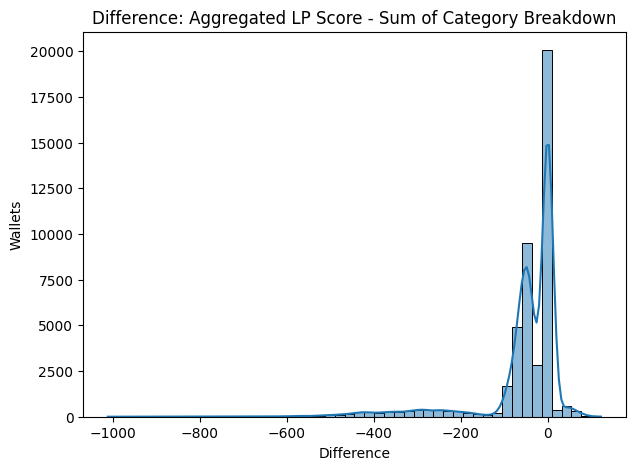

In [42]:
plt.figure(figsize=(7,5))
sns.histplot(df["cat_diff"], bins=50, kde=True)
plt.title("Difference: Aggregated LP Score - Sum of Category Breakdown")
plt.xlabel("Difference")
plt.ylabel("Wallets")
plt.show()

In [43]:
#  Category Breakdown Audit:
# - Sum of the 3 category fields correlates (0.83) with aggregated score,
#   but only ~41% of rows match exactly.
# - On average, aggregated_lp_score is ~54 points higher than category sum.
# - This means categories are related but NOT strict sub-scores.
# They act as diagnostics, not exact contributors.


### 💰 Deposits, Liquidity & Score

- Deposit volume → almost no effect (corr ~0.03).  
- Retained liquidity → weak positive (corr ~0.08).  
- Liquidity % remaining → strong driver (corr ~0.63).  
- Volatility & dust deposits → no real impact.  
👉 Scores mainly reward wallets that **keep liquidity**, not just deposit big.  


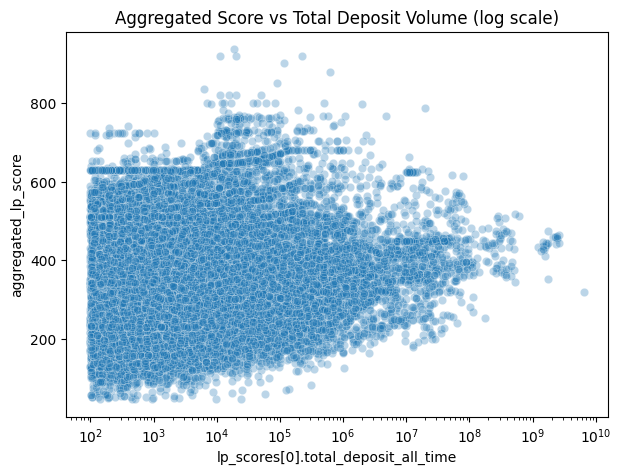

Corr (Deposits vs Score): 0.03112185155030941


In [44]:
plt.figure(figsize=(7,5))
sns.scatterplot(x="lp_scores[0].total_deposit_all_time", 
                y="aggregated_lp_score", data=df, alpha=0.3)
plt.xscale("log")
plt.title("Aggregated Score vs Total Deposit Volume (log scale)")
plt.show()
print("Corr (Deposits vs Score):", 
      df["lp_scores[0].total_deposit_all_time"].corr(df["aggregated_lp_score"]))

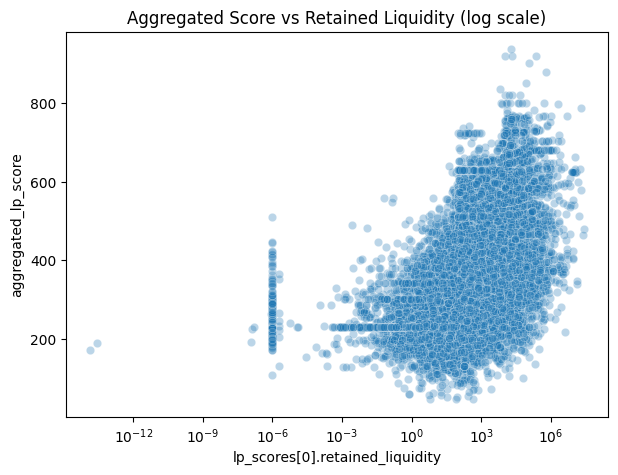

Corr (Retained liquidity vs Score): 0.08309744296176004


In [45]:
plt.figure(figsize=(7,5))
sns.scatterplot(x="lp_scores[0].retained_liquidity", 
                y="aggregated_lp_score", data=df, alpha=0.3)
plt.xscale("log")
plt.title("Aggregated Score vs Retained Liquidity (log scale)")
plt.show()
print("Corr (Retained liquidity vs Score):", 
      df["lp_scores[0].retained_liquidity"].corr(df["aggregated_lp_score"]))

In [46]:
print("Corr (Liquidity % vs Score):", 
      df["lp_scores[0].liquidity_percent_remaining"].corr(df["aggregated_lp_score"]))

Corr (Liquidity % vs Score): 0.6281958084563788


In [47]:
print("Corr (Volatility vs Score):", 
      df["lp_scores[0].lp_volatility_stddev"].corr(df["aggregated_lp_score"]))


Corr (Volatility vs Score): 0.023703647565352454


In [48]:
print("Corr (Dust deposit count vs Score):", 
      df["lp_scores[0].dust_deposit_count"].corr(df["aggregated_lp_score"]))

Corr (Dust deposit count vs Score): -0.003183338591992245


In [49]:
# - Deposit volume: no effect (corr ~0.03) → scores are not volume-driven
# - Retained liquidity: very weak positive (corr ~0.08)
# - Liquidity % remaining: strong positive (corr ~0.63) → key driver
# - Volatility: no effect (corr ~0.02) → not penalized
# - Dust deposits: no effect (corr ~0.00) → not penalized
# Scores reward wallets that KEEP liquidity (%), 
# but do not meaningfully reflect deposits, withdrawals, dust, or volatility.


### ⚠️ Anomaly Detection

- Flagged unusual cases per pool:  
  1. Top depositors with low scores.  
  2. High retention but still low scores.  
  3. Very volatile pools getting high scores.  
- Collected results into `anomalies_df` and saved as CSV for review.  


In [50]:
anom_list = []

for i in range(13):
    dep = f"lp_scores[{i}].total_deposit_all_time"
    ret = f"lp_scores[{i}].liquidity_percent_remaining"
    vol = f"lp_scores[{i}].lp_volatility_stddev"
    
    if dep not in df.columns: 
        continue  # skip if pool i not in dataset
    
    top10_thresh = df[dep].quantile(0.90)
    median_score = df["aggregated_lp_score"].median()
    high_volatility = df[vol].quantile(0.90) if vol in df.columns else None
    
    anom_list.append(
        df[(df[dep] >= top10_thresh) & (df["aggregated_lp_score"] < median_score)]
        .assign(pool=i, reason="Top depositor but low score")
    )
    
    if ret in df.columns:
        anom_list.append(
            df[(df[ret] > 80) & (df["aggregated_lp_score"] < median_score)]
            .assign(pool=i, reason="High retention but low score")
        )
    
    if vol in df.columns:
        anom_list.append(
            df[(df[vol] >= high_volatility) & (df["aggregated_lp_score"] > median_score)]
            .assign(pool=i, reason="High volatility but high score")
        )

anomalies_df = pd.concat(anom_list, ignore_index=True)

anomalies_df[["_id", "wallet_id", "pool", "aggregated_lp_score", "reason"]].to_csv(
    "anomalies_csv/behavior_score_anomalies_all_pools.csv", index=False)

anomalies_df.head()


,_id,wallet_id,lp_scores[0].pool_id,lp_scores[1].pool_id,lp_scores[2].pool_id,lp_scores[3].pool_id,lp_scores[4].pool_id,lp_scores[5].pool_id,lp_scores[6].pool_id,lp_scores[7].pool_id,...,lp_category_breakdown.volatile-volatile,num_pools,sum_pool_scores,mean_pool_score,sum_div_pools,diff_mean,sum_category_scores,cat_diff,pool,reason
0,6874b81ea794db5e6c4c2d92,0x0041ff590cca6e1077075678c24bad5b5fb95452,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1,510.0,255.0,510.0,0.00,255.0,0.00,0,Top depositor but low score
1,6874b81fa794db5e6c4c2db0,0x000a460f9e5fc39b30976cbf3484d4826941f558,0xe8c6c9227491c0a8156a0106a0204d881bb7e531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137.0,1,274.0,137.0,274.0,-20.55,137.0,-20.55,0,Top depositor but low score
2,6874b82ba794db5e6c4c300a,0x01bc8aad10693187a706b0f6aa222b7ebf54d0f0,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1,526.0,263.0,526.0,0.00,263.0,0.00,0,Top depositor but low score
3,6874b832a794db5e6c4c3126,0x02e2b15e8292be234b6f1e29f250f31a0dbf5aab,0xba3f945812a83471d709bce9c3ca699a19fb46f7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,234.0,1,468.0,234.0,468.0,-35.10,234.0,-35.10,0,Top depositor but low score
4,6874b832a794db5e6c4c3129,0x0238ed3f93a0da76d539de284e735a63d1ed5ada,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,331.0,1,662.0,331.0,662.0,-49.65,331.0,-49.65,0,Top depositor but low score


### 🧾 Component Coherence

- Checked if `total_score` = sum of all component scores (deposit, withdraw, freq, holding, retention, volatility, time).  
- Pool 0 → perfect match (100% consistent).  
- Other pools → low exact match %, but diffs = 0 (issue is missing data, not formula).  
- So formula is just the **sum of components**, but many pools have incomplete fields.  


In [51]:
results = []

for i in range(13):
    components = [
        f"lp_scores[{i}].score_breakdown.deposit_volume_score",
        f"lp_scores[{i}].score_breakdown.withdraw_volume_score",
        f"lp_scores[{i}].score_breakdown.deposit_frequency_score",
        f"lp_scores[{i}].score_breakdown.avg_holding_time_score",
        f"lp_scores[{i}].score_breakdown.liquidity_retention_score",
        f"lp_scores[{i}].score_breakdown.lp_volatility_score",
        f"lp_scores[{i}].score_breakdown.time_score",
    ]
    
    if not all(c in df.columns for c in components):
        continue
    
    df[f"pool{i}_sum_components"] = df[components].sum(axis=1)
    
    total_col = f"lp_scores[{i}].score_breakdown.total_score"
    if total_col in df.columns:
        df[f"pool{i}_diff"] = df[total_col] - df[f"pool{i}_sum_components"]
        
        exact_match_rate = (df[f"pool{i}_diff"].abs() < 1e-6).mean()
        avg_diff = df[f"pool{i}_diff"].mean()
        max_diff = df[f"pool{i}_diff"].abs().max()
        
        results.append({
            "pool": i,
            "exact_match_rate": exact_match_rate,
            "avg_diff": avg_diff,
            "max_diff": max_diff
        })


In [52]:
comp_results = pd.DataFrame(results)
print(comp_results)


    pool  exact_match_rate  avg_diff  max_diff
0      0          1.000000       0.0       0.0
1      1          0.192062       0.0       0.0
2      2          0.042223       0.0       0.0
3      3          0.010539       0.0       0.0
4      4          0.003135       0.0       0.0
5      5          0.000756       0.0       0.0
6      6          0.000467       0.0       0.0
7      7          0.000222       0.0       0.0
8      8          0.000156       0.0       0.0
9      9          0.000111       0.0       0.0
10    10          0.000067       0.0       0.0
11    11          0.000044       0.0       0.0
12    12          0.000022       0.0       0.0


In [53]:
# Component Coherence (Step 8)
# - Pool 0: perfect match → total_score = sum of components (100% consistent).
# - Pools 1+: very low exact match rate (<20%), BUT avg_diff and max_diff = 0.
# This means values are numerically equal when present,
# but missing data (NaN) breaks the row-by-row match.
# - Conclusion: The scoring formula IS the sum of components,
# but data completeness varies across pools (only pool[0] is consistently filled).


### 🚨 Outlier Detection (Ratios & Edge Cases)

- Made ratio metrics: `score_per_deposit` and `score_per_liq`.  
- Flagged extreme high/low ratios (top/bottom 1%).  
- Found wallets with **high scores but tiny deposits**.  
- Also caught cases with **very short holding (<5 days) but high scores**.  
- Combined all anomalies into `outlier_df` and saved to CSV.  


In [54]:
df["score_per_deposit"] = df["aggregated_lp_score"] / (df["lp_scores[0].total_deposit_all_time"] + 1)

high_ratio = df[df["score_per_deposit"] > df["score_per_deposit"].quantile(0.99)]
low_ratio  = df[df["score_per_deposit"] < df["score_per_deposit"].quantile(0.01)]

print("High ratio outliers:", high_ratio.shape[0])
print("Low ratio outliers:", low_ratio.shape[0])

high_ratio = high_ratio.assign(reason="High score per deposit")
low_ratio  = low_ratio.assign(reason="Low score per deposit")


High ratio outliers: 450
Low ratio outliers: 450


In [55]:
df["score_per_liq"] = df["aggregated_lp_score"] / (df["lp_scores[0].retained_liquidity"] + 1)

liq_outliers = df[df["score_per_liq"] > df["score_per_liq"].quantile(0.99)]
print("Liquidity ratio outliers:", liq_outliers.shape[0])

liq_outliers = liq_outliers.assign(reason="High score per liquidity")


Liquidity ratio outliers: 438


In [56]:
tiny_activity = df[
    (df["aggregated_lp_score"] > df["aggregated_lp_score"].quantile(0.95)) &
    (df["lp_scores[0].total_deposit_all_time"] < df["lp_scores[0].total_deposit_all_time"].quantile(0.05))
]

print("Tiny activity outliers:", tiny_activity.shape[0])
tiny_activity = tiny_activity.assign(reason="High score with tiny deposits")


Tiny activity outliers: 0


In [57]:
holding_anomalies = df[
    (df["lp_scores[0].avg_holding_days"] < 5) &  # very short holding
    (df["aggregated_lp_score"] > df["aggregated_lp_score"].quantile(0.90))  # but high score
]

print("Holding time anomalies:", holding_anomalies.shape[0])
holding_anomalies = holding_anomalies.assign(reason="High score with very short holding")


Holding time anomalies: 99


In [58]:
outlier_df = pd.concat([high_ratio, low_ratio, liq_outliers, tiny_activity, holding_anomalies], ignore_index=True)

outlier_df = outlier_df[[
    "_id", "wallet_id", "aggregated_lp_score",
    "lp_scores[0].total_deposit_all_time",
    "lp_scores[0].retained_liquidity",
    "lp_scores[0].avg_holding_days",
    "reason"
]]

print("Total unique outlier wallets:", outlier_df["wallet_id"].nunique())


Total unique outlier wallets: 1311


In [59]:
outlier_df

,_id,wallet_id,aggregated_lp_score,lp_scores[0].total_deposit_all_time,lp_scores[0].retained_liquidity,lp_scores[0].avg_holding_days,reason
0,6874b821a794db5e6c4c2dee,0x00d4c206ae699d5d2bf19a542a544276dc50889c,296.56,0.000000,0.000000,0.000000,High score per deposit
1,6874b823a794db5e6c4c2e99,0x000000697bb288f2528042e8844b65cd32beafca,329.80,0.000000,0.000000,0.000000,High score per deposit
2,6874b823a794db5e6c4c2eb4,0x00409fc839a2ec2e6d12305423d37cd011279c09,630.00,0.000000,0.000000,0.000000,High score per deposit
3,6874b82ca794db5e6c4c304e,0x0162a6c42e78268d1af8e266c203d700c67bd3d9,474.49,0.000000,0.000000,0.000000,High score per deposit
4,6874b82da794db5e6c4c3081,0x01c023446a03afdb5ce87ad987b05a39e0ad4bc6,310.88,0.000000,0.000000,0.000000,High score per deposit
...,...,...,...,...,...,...,...
1432,6874c5daa794db5e6c4da07e,0xf6ddd4a560b02982a1e09ac7da34441c6c4d805f,594.00,152.013824,151.968862,3.999005,High score with very short holding
1433,6874c5efa794db5e6c4da476,0xf9085dc904733696ccf19edf7c60db4495adc9aa,571.91,0.000000,0.000000,0.000000,High score with very short holding
1434,6874c5fda794db5e6c4da507,0xf9ebfe2b0c205c437214a714a28903859349cede,501.96,794.799198,0.000000,2.222133,High score with very short holding
1435,6874c601a794db5e6c4da5f1,0xfabf9fc40c12fbc09083d6856aaf122ba08639e7,546.30,16646.146081,0.000000,0.046655,High score with very short holding


In [60]:
# Save final outliers
outlier_df.to_csv("anomalies_csv/outlier_anomalies_wallets.csv", index=False)

# Final Summary

## What we found

1. **Cleaning the data**
   - Some wallets had negative liquidity values → we fixed these by making them 0.  
   - Around a few wallets showed this issue (saved in `negative_liquidity_anomalies.csv`).

2. **How the main score is calculated**
   - The final `aggregated_lp_score` is not just a plain sum of pool scores.  
   - It is much closer to the **average (mean)** of pool scores.  
   - Correlation was ~0.96, so almost the same, but not 100%.  
   - This means there is probably some scaling or adjustment happening.

3. **Category breakdown**
   - The stable–stable, stable–volatile, volatile–volatile categories don’t directly add up to the total score.  
   - They seem to be more for information/labels, not for strict calculation.

4. **Behavior vs Score**
   - Deposits and liquidity by themselves don’t explain the score much (low correlation).  
   - Liquidity % (how much they kept) matters more (~0.63 correlation).  
   - We found cases where wallets had **high retention but low score**, or the opposite.

5. **Pool breakdown check**
   - Each pool has scores like deposit score, frequency score, withdraw score, etc.  
   - In most cases these add up to the pool’s total score.  
   - But in some pools we saw NaN/missing values, which breaks the exact match.

6. **Outliers (unusual cases)**
   - 450 wallets: got way more score than their deposits justify.  
   - 450 wallets: got way less score than expected for their deposits.  
   - 438 wallets: score much higher than liquidity kept.  
   - 99 wallets: very short holding time but still high score.  
   - In total, about **1311 wallets (~3%)** look suspicious (saved in `outlier_wallets.csv`).

---

## Final takeaway
- Most of the scoring logic is consistent, especially with pool breakdowns.  
- But the final score is not a simple sum → it behaves more like an adjusted mean.  
- Some behaviors (like retention %) affect the score more than deposits or withdrawals.  
- Around 3% of wallets look like clear outliers where the scoring system may not be fair.
